In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import pickle
import os
try:
    filepath = os.path.dirname(os.path.abspath(__file__))
except:
    

NameError: name '__file__' is not defined

In [2]:
# This is for hyperparameters tuning
X_train = pd.DataFrame(np.load(filepath + '/data/X_train.npz')['X_train'])
X_val = pd.DataFrame(np.load(filepath + '/data/X_val.npz')['X_val'])

y_train = np.load(filepath + '/data/y_train.npz')['y_train']
y_val = np.load(filepath + '/data/y_val.npz')['y_val']

# This is for training the final models
X = X_train.append(X_val)
y = np.append(y_train, y_val)

In [3]:
def rmse(*args):
    """ Funcion that calculates the root mean squared error"""
    return np.sqrt(mean_squared_error(*args))
def clip20(x):
    return np.clip(x, 0, 20)

## Stacking approach

The final model will be an ensemble that uses the stacking approach.

So there will be 3 **base models**:
- Light Gradient Boosting (lightgbm)
- XGBoost
- Random Forest

And the meta-model will be a **Linear Regression**

## Metrics

The metric that's being used is "RMSE" because that's what has to be optimized in the final model.

## Hyperparameter Tuning

### A. Light Gradient Boosting

This is done so as to find the best parameters of the "lightgbm" model.

Here I find the best learning rate by training and validating.  
An RMSE is computed after clipping the 'y' values because that's how the results will be evaluated in the leaderboard.

In [4]:
learning_rates = [0.02, 0.03, 0.04, 0.06, 0.08]
best_rmse = 9999999999999
for lr in learning_rates:
    lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': lr, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0,
               'num_threads':-1,
              }

    lgb_model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), int(100 * (lr / 0.03)))
    pred_lgb_val = lgb_model.predict(X_val)
    score = rmse(clip20(y_val), clip20(pred_lgb_val))

    if score < best_rmse:
        best_rmse = score
        best_lr = lr
        best_lgb = lgb_model

In [5]:
best_lr

0.06

#### Final training

In [85]:
lgb_params = {
               'feature_fraction': 0.8,
               'metric': 'rmse',
               'nthread':-1, 
               'min_data_in_leaf': 2, 
               'bagging_fraction': 0.75, 
               'learning_rate': best_lr, 
               'objective': 'mse', 
               'bagging_seed': 100, 
               'num_leaves': 16,
               'bagging_freq':1,
               'max_depth': 16,
               'verbose':2,
              }
best_lgb = lgb.train(lgb_params, lgb.Dataset(X, label=y),100)

In [86]:
filename = 'models/best_lgb.pkl'
pickle.dump(best_lgb, open(filename, 'wb'))

## Feature Importance

This is to check if features really contribute to the model.

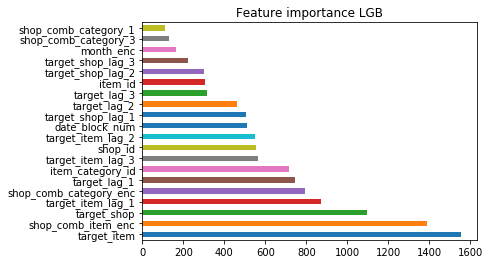

In [84]:
import matplotlib.pyplot as plt
%matplotlib inline 

feat_importances = pd.Series(best_lgb.feature_importance(), index=X_val.columns)
feat_importances = feat_importances.nlargest(20)
feat_importances.plot(kind='barh')
plt.title('Feature importance LGB')
plt.show()

### B. XGBoost

Here I do a randomized grid search so that it ends faster.

Best model

    RandomizedSearchCV(cv=None, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='rmse', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=-1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

# A parameter grid for XGBoost
params = {'min_child_weight':[4,5],
          'gamma':[i/10.0 for i in range(3,5)],
          'subsample':[i/10.0 for i in range(6,8)],
          'colsample_bytree':[i/10.0 for i in range(6,8)],
          'max_depth': [2,3]}

# Initialize XGB and GridSearch
xgb_model = XGBRegressor(n_jobs=-1, eval_metric='rmse')

train_ind=np.zeros(X.shape[0])
for i in range(0, len(X_train)):
    train_ind[i] = -1
ps = PredefinedSplit(test_fold=(train_ind))

best_xgb = RandomizedSearchCV(xgb_model, params, verbose=3, n_jobs=-1, cv=ps)
best_xgb.fit(X, y, verbose=True)

# best_xgb = XGBRegressor(random_state=100,
#                      n_estimators=30,
#                      max_depth=10,
#                      n_jobs=4,
#                      eval_metric='rmse')
# best_xgb.fit(X, y, verbose=True)

In [10]:
filename = 'models/best_xgb.pkl'
pickle.dump(best_xgb, open(filename, 'wb'))

### B. Random Forest

Trained with an increased "min_samples_leaf" because it's been overfitting.

In [31]:
from sklearn.ensemble import RandomForestRegressor

params={'max_features':[4, 6, 8], 
        'max_depth': [2, 8],
        'min_samples_leaf' : [8, 16, 20]}

rf_model = RandomForestRegressor(n_estimators=16, n_jobs=-1, random_state=100, criterion='mse', verbose=2)
best_rf = RandomizedSearchCV(rf_model, params, scoring = 'neg_mean_squared_error', n_jobs=-1, verbose=3)
best_rf.fit(X, y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] min_samples_leaf=20, max_features=8, max_depth=8 ................
[CV] min_samples_leaf=20, max_features=8, max_depth=8 ................
building tree 1 of 16
building tree 2 of 16
building tree 3 of 16
building tree 4 of 16
[CV] min_samples_leaf=20, max_features=8, max_depth=8 ................
building tree 1 of 16
building tree 2 of 16
building tree 4 of 16
building tree 3 of 16
[CV] min_samples_leaf=8, max_features=6, max_depth=2 .................
building tree 1 of 16
building tree 4 of 16
building tree 3 of 16
building tree 2 of 16
building tree 1 of 16
building tree 3 of 16
building tree 2 of 16
building tree 4 of 16
building tree 5 of 16
building tree 6 of 16
building tree 7 of 16
building tree 8 of 16
building tree 9 of 16
building tree 10 of 16
building tree 11 of 16
building tree 12 of 16
building tree 13 of 16
building tree 5 of 16
building tree 14 of 16
building tree 6 of 16
building tree 15 of 16
building tr

[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   28.8s finished


building tree 8 of 16


[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.4s finished


[CV]  min_samples_leaf=8, max_features=6, max_depth=2, score=-7.193517242392016, total=  36.1s
[CV] min_samples_leaf=8, max_features=6, max_depth=2 .................
building tree 2 of 16
building tree 4 of 16
building tree 1 of 16
building tree 3 of 16
building tree 9 of 16
building tree 5 of 16
building tree 10 of 16
building tree 6 of 16
building tree 11 of 16
building tree 7 of 16
building tree 8 of 16
building tree 9 of 16
building tree 12 of 16
building tree 10 of 16
building tree 11 of 16
building tree 9 of 16
building tree 10 of 16
building tree 11 of 16
building tree 9 of 16
building tree 12 of 16
building tree 10 of 16
building tree 12 of 16
building tree 11 of 16
building tree 13 of 16
building tree 14 of 16
building tree 12 of 16
building tree 15 of 16
building tree 16 of 16


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   28.0s finished
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.5s finished


building tree 13 of 16
[CV]  min_samples_leaf=8, max_features=6, max_depth=2, score=-11.912177116201129, total=  35.7s
[CV] min_samples_leaf=8, max_features=6, max_depth=2 .................
building tree 14 of 16
building tree 15 of 16
building tree 13 of 16
building tree 14 of 16
building tree 15 of 16
building tree 16 of 16
building tree 2 of 16
building tree 3 of 16
building tree 1 of 16
building tree 4 of 16
building tree 13 of 16
building tree 14 of 16
building tree 16 of 16
building tree 15 of 16
building tree 5 of 16
building tree 6 of 16
building tree 7 of 16
building tree 8 of 16
building tree 16 of 16
building tree 9 of 16
building tree 10 of 16
building tree 11 of 16
building tree 12 of 16
building tree 13 of 16
building tree 14 of 16
building tree 15 of 16
building tree 16 of 16


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   27.2s finished
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  1.9min finished
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  1.9min finished


[CV]  min_samples_leaf=8, max_features=6, max_depth=2, score=-9.168296080245538, total=  34.1s
[CV] min_samples_leaf=8, max_features=8, max_depth=8 .................


[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.9s finished


[CV]  min_samples_leaf=20, max_features=8, max_depth=8, score=-3.9832227861340326, total= 2.0min
[CV] min_samples_leaf=8, max_features=8, max_depth=8 .................


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  1.9min finished
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.4s finished


[CV]  min_samples_leaf=20, max_features=8, max_depth=8, score=-8.25706250658346, total= 2.0min
building tree 1 of 16
building tree 2 of 16
building tree 4 of 16
building tree 3 of 16
[CV] min_samples_leaf=8, max_features=8, max_depth=8 .................
building tree 2 of 16
building tree 3 of 16
building tree 1 of 16
building tree 4 of 16


[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    1.3s finished


[CV]  min_samples_leaf=20, max_features=8, max_depth=8, score=-6.259116243528529, total= 2.0min
[CV] min_samples_leaf=20, max_features=4, max_depth=8 ................
building tree 1 of 16
building tree 3 of 16
building tree 2 of 16
building tree 4 of 16
building tree 1 of 16
building tree 3 of 16
building tree 2 of 16
building tree 4 of 16
building tree 5 of 16
building tree 5 of 16
building tree 6 of 16
building tree 6 of 16
building tree 7 of 16
building tree 8 of 16
building tree 5 of 16
building tree 7 of 16
building tree 6 of 16
building tree 8 of 16
building tree 7 of 16
building tree 8 of 16
building tree 5 of 16
building tree 6 of 16
building tree 7 of 16
building tree 8 of 16
building tree 9 of 16
building tree 10 of 16
building tree 11 of 16
building tree 12 of 16
building tree 9 of 16
building tree 10 of 16
building tree 11 of 16
building tree 9 of 16
building tree 13 of 16
building tree 10 of 16
building tree 12 of 16
building tree 11 of 16
building tree 14 of 16
building 

[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  1.3min finished
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.8s finished


building tree 13 of 16
building tree 14 of 16
building tree 15 of 16
building tree 13 of 16


[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    1.7s finished


[CV]  min_samples_leaf=20, max_features=4, max_depth=8, score=-4.941352183780466, total= 1.4min
[CV] min_samples_leaf=20, max_features=4, max_depth=8 ................
building tree 14 of 16
building tree 15 of 16
building tree 16 of 16
building tree 13 of 16
building tree 14 of 16
building tree 15 of 16
building tree 16 of 16
building tree 3 of 16
building tree 2 of 16
building tree 1 of 16
building tree 4 of 16
building tree 16 of 16
building tree 5 of 16
building tree 6 of 16
building tree 7 of 16
building tree 8 of 16


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.1min finished
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.1min finished


building tree 9 of 16


[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.6s finished


building tree 10 of 16


[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    1.2s finished


[CV]  min_samples_leaf=8, max_features=8, max_depth=8, score=-3.6224458748192725, total= 2.2min
building tree 11 of 16
[CV] min_samples_leaf=20, max_features=4, max_depth=8 ................
building tree 12 of 16


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.1min finished
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    1.2s finished


[CV]  min_samples_leaf=8, max_features=8, max_depth=8, score=-8.038944245720343, total= 2.2min
[CV] min_samples_leaf=16, max_features=4, max_depth=2 ................
building tree 2 of 16
building tree 4 of 16
building tree 3 of 16
building tree 1 of 16


[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    1.2s finished


[CV]  min_samples_leaf=8, max_features=8, max_depth=8, score=-5.900979327723355, total= 2.2min
[CV] min_samples_leaf=16, max_features=4, max_depth=2 ................
building tree 4 of 16
building tree 3 of 16
building tree 1 of 16
building tree 2 of 16
building tree 5 of 16
building tree 13 of 16
building tree 6 of 16
building tree 3 of 16
building tree 1 of 16
building tree 4 of 16
building tree 2 of 16
building tree 7 of 16
building tree 14 of 16
building tree 8 of 16
building tree 15 of 16
building tree 16 of 16
building tree 9 of 16
building tree 5 of 16
building tree 10 of 16
building tree 6 of 16
building tree 7 of 16
building tree 8 of 16
building tree 11 of 16
building tree 12 of 16
building tree 9 of 16
building tree 13 of 16
building tree 14 of 16
building tree 10 of 16
building tree 5 of 16
building tree 6 of 16
building tree 15 of 16
building tree 11 of 16
building tree 7 of 16
building tree 8 of 16
building tree 12 of 16
building tree 16 of 16
building tree 13 of 16
build

[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   20.3s finished
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  1.0min finished
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   19.7s finished
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.6s finished


[CV]  min_samples_leaf=16, max_features=4, max_depth=2, score=-7.425060114910326, total=  26.6s
[CV] min_samples_leaf=16, max_features=4, max_depth=2 ................
building tree 9 of 16


[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.4s finished


[CV]  min_samples_leaf=16, max_features=4, max_depth=2, score=-12.231326999219432, total=  26.4s
[CV] min_samples_leaf=16, max_features=8, max_depth=2 ................
building tree 10 of 16
building tree 11 of 16
building tree 12 of 16


[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    1.2s finished


[CV]  min_samples_leaf=20, max_features=4, max_depth=8, score=-8.890222833348862, total= 1.1min
[CV] min_samples_leaf=16, max_features=8, max_depth=2 ................
building tree 1 of 16
building tree 2 of 16
building tree 4 of 16
building tree 3 of 16
building tree 5 of 16
building tree 4 of 16
building tree 1 of 16
building tree 2 of 16
building tree 3 of 16
building tree 6 of 16
building tree 7 of 16
building tree 8 of 16
building tree 2 of 16
building tree 3 of 16
building tree 1 of 16
building tree 4 of 16
building tree 9 of 16
building tree 13 of 16
building tree 10 of 16
building tree 11 of 16
building tree 5 of 16
building tree 12 of 16
building tree 5 of 16
building tree 6 of 16
building tree 7 of 16
building tree 13 of 16
building tree 8 of 16
building tree 14 of 16
building tree 6 of 16
building tree 7 of 16
building tree 14 of 16
building tree 8 of 16
building tree 15 of 16
building tree 15 of 16
building tree 16 of 16
building tree 16 of 16
building tree 9 of 16
building

[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   21.5s finished


building tree 10 of 16
building tree 11 of 16
building tree 12 of 16


[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.1s finished


building tree 12 of 16


[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.4s finished


building tree 13 of 16
[CV]  min_samples_leaf=16, max_features=4, max_depth=2, score=-9.35353146987425, total=  27.1s
building tree 14 of 16
[CV] min_samples_leaf=16, max_features=8, max_depth=2 ................
building tree 15 of 16
building tree 13 of 16
building tree 14 of 16
building tree 15 of 16
building tree 16 of 16
building tree 16 of 16


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  1.1min finished


building tree 2 of 16
building tree 1 of 16
building tree 4 of 16
building tree 3 of 16


[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   32.4s finished
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   31.8s finished


building tree 5 of 16


[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    1.0s finished


[CV]  min_samples_leaf=20, max_features=4, max_depth=8, score=-6.69300340271639, total= 1.2min
[CV] min_samples_leaf=8, max_features=6, max_depth=8 .................
building tree 6 of 16
building tree 7 of 16


[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.1s finished


building tree 8 of 16


[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.2s finished


[CV]  min_samples_leaf=16, max_features=8, max_depth=2, score=-6.54219661903538, total=  38.8s
[CV] min_samples_leaf=8, max_features=6, max_depth=8 .................


[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.3s finished


[CV]  min_samples_leaf=16, max_features=8, max_depth=2, score=-11.434116132392056, total=  38.8s
[CV] min_samples_leaf=8, max_features=6, max_depth=8 .................
building tree 9 of 16
building tree 10 of 16
building tree 11 of 16
building tree 2 of 16
building tree 3 of 16
building tree 4 of 16
building tree 1 of 16
building tree 12 of 16
building tree 1 of 16
building tree 2 of 16
building tree 4 of 16
building tree 3 of 16
building tree 1 of 16
building tree 4 of 16
building tree 2 of 16
building tree 3 of 16
building tree 13 of 16
building tree 14 of 16
building tree 15 of 16
building tree 16 of 16


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   28.8s finished
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.1s finished


building tree 5 of 16
building tree 6 of 16
building tree 7 of 16


[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.5s finished


[CV]  min_samples_leaf=16, max_features=8, max_depth=2, score=-8.919222161694282, total=  36.1s
building tree 5 of 16
[CV] min_samples_leaf=8, max_features=4, max_depth=8 .................
building tree 6 of 16
building tree 7 of 16
building tree 5 of 16
building tree 8 of 16
building tree 6 of 16
building tree 7 of 16
building tree 8 of 16
building tree 8 of 16
building tree 3 of 16
building tree 2 of 16
building tree 4 of 16
building tree 1 of 16
building tree 9 of 16
building tree 10 of 16
building tree 11 of 16
building tree 9 of 16
building tree 5 of 16
building tree 6 of 16
building tree 9 of 16
building tree 7 of 16
building tree 8 of 16
building tree 10 of 16
building tree 11 of 16
building tree 12 of 16
building tree 10 of 16
building tree 11 of 16
building tree 12 of 16
building tree 12 of 16
building tree 9 of 16
building tree 10 of 16
building tree 11 of 16
building tree 12 of 16
building tree 13 of 16
building tree 14 of 16
building tree 15 of 16
building tree 13 of 16
bui

[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  1.2min finished
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  1.6min finished
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  1.6min finished
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.8s finished


[CV]  min_samples_leaf=8, max_features=6, max_depth=8, score=-4.566562865810563, total= 1.8min
[CV] min_samples_leaf=8, max_features=4, max_depth=8 .................


[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.8s finished


[CV]  min_samples_leaf=8, max_features=4, max_depth=8, score=-4.627607598559626, total= 1.3min
[CV] min_samples_leaf=8, max_features=4, max_depth=8 .................


[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.7s finished


[CV]  min_samples_leaf=8, max_features=6, max_depth=8, score=-8.244570756972998, total= 1.7min
[CV] min_samples_leaf=20, max_features=6, max_depth=2 ................


[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.6s finished


[CV]  min_samples_leaf=8, max_features=6, max_depth=8, score=-6.198042552473691, total= 1.8min
[CV] min_samples_leaf=20, max_features=6, max_depth=2 ................
building tree 3 of 16
building tree 2 of 16
building tree 1 of 16
building tree 4 of 16
building tree 3 of 16
building tree 1 of 16
building tree 2 of 16
building tree 4 of 16
building tree 3 of 16
building tree 4 of 16
building tree 1 of 16
building tree 2 of 16
building tree 2 of 16
building tree 1 of 16
building tree 3 of 16
building tree 4 of 16
building tree 5 of 16
building tree 6 of 16
building tree 7 of 16
building tree 8 of 16
building tree 5 of 16
building tree 6 of 16
building tree 7 of 16
building tree 8 of 16
building tree 9 of 16
building tree 10 of 16
building tree 9 of 16
building tree 11 of 16
building tree 10 of 16
building tree 5 of 16
building tree 6 of 16
building tree 12 of 16
building tree 11 of 16
building tree 5 of 16
building tree 7 of 16
building tree 8 of 16
building tree 6 of 16
building tree 1

[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   25.5s finished
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   25.3s finished


building tree 9 of 16


[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.1s finished


building tree 10 of 16
building tree 9 of 16
building tree 11 of 16


[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.3s finished


building tree 12 of 16
[CV]  min_samples_leaf=20, max_features=6, max_depth=2, score=-7.318229224521506, total=  29.1s
[CV] min_samples_leaf=20, max_features=6, max_depth=2 ................
building tree 10 of 16
building tree 11 of 16


[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.4s finished


building tree 12 of 16
[CV]  min_samples_leaf=20, max_features=6, max_depth=2, score=-12.054121351958866, total=  30.4s
[CV] min_samples_leaf=8, max_features=4, max_depth=2 .................
building tree 3 of 16
building tree 4 of 16
building tree 2 of 16
building tree 1 of 16
building tree 2 of 16
building tree 4 of 16
building tree 1 of 16
building tree 3 of 16
building tree 5 of 16
building tree 6 of 16
building tree 5 of 16
building tree 7 of 16
building tree 13 of 16
building tree 6 of 16
building tree 7 of 16
building tree 8 of 16
building tree 8 of 16
building tree 13 of 16
building tree 14 of 16
building tree 15 of 16
building tree 16 of 16
building tree 9 of 16
building tree 9 of 16
building tree 14 of 16
building tree 15 of 16
building tree 16 of 16
building tree 10 of 16
building tree 10 of 16
building tree 11 of 16
building tree 11 of 16
building tree 12 of 16
building tree 12 of 16
building tree 13 of 16
building tree 14 of 16
building tree 15 of 16
building tree 13 of 16

[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   19.0s finished
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   59.4s finished
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.2s finished


[CV]  min_samples_leaf=8, max_features=4, max_depth=2, score=-7.888685037194504, total=  25.4s


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   24.0s finished


[CV] min_samples_leaf=8, max_features=4, max_depth=2 .................


[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   59.9s finished
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.6s finished


[CV]  min_samples_leaf=8, max_features=4, max_depth=8, score=-8.808770849771536, total= 1.0min


[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.2s finished


[CV]  min_samples_leaf=20, max_features=6, max_depth=2, score=-9.1774801402023, total=  29.5s
[CV] min_samples_leaf=8, max_features=4, max_depth=2 .................


[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.5s finished


building tree 3 of 16
building tree 1 of 16
building tree 4 of 16
building tree 2 of 16
[CV]  min_samples_leaf=8, max_features=4, max_depth=8, score=-6.245221144836595, total= 1.0min
building tree 5 of 16
building tree 6 of 16
building tree 7 of 16
building tree 8 of 16
building tree 1 of 16
building tree 2 of 16
building tree 3 of 16
building tree 4 of 16
building tree 9 of 16
building tree 10 of 16
building tree 11 of 16
building tree 5 of 16
building tree 6 of 16
building tree 7 of 16
building tree 8 of 16
building tree 12 of 16
building tree 13 of 16
building tree 14 of 16
building tree 9 of 16
building tree 15 of 16
building tree 10 of 16
building tree 16 of 16
building tree 11 of 16
building tree 12 of 16
building tree 13 of 16
building tree 14 of 16
building tree 15 of 16


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    7.8s finished


building tree 16 of 16


[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    7.5s finished
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.2s finished


[CV]  min_samples_leaf=8, max_features=4, max_depth=2, score=-12.174535810398933, total=  11.1s


[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.2s finished


[CV]  min_samples_leaf=8, max_features=4, max_depth=2, score=-9.280588526705692, total=  10.1s


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  8.5min finished


building tree 1 of 16building tree 2 of 16building tree 3 of 16building tree 4 of 16



building tree 5 of 16
building tree 6 of 16
building tree 7 of 16
building tree 8 of 16
building tree 9 of 16
building tree 10 of 16
building tree 11 of 16
building tree 12 of 16
building tree 13 of 16
building tree 14 of 16
building tree 15 of 16
building tree 16 of 16


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   43.2s finished


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=16, n_jobs=-1,
           oob_score=False, random_state=100, verbose=2, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'max_features': [4, 6, 8], 'max_depth': [2, 8], 'min_samples_leaf': [8, 16, 20]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=3)

In [32]:
filename = 'models/best_rf.pkl'
pickle.dump(best_rf, open(filename, 'wb'))